In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import product

In [2]:
# read data into program
id = "774725"

rawdata = pd.read_csv("data/Project1_PartB_data/"+id+"_partB.csv")
print("Number of observations: " + str(len(rawdata)))

Number of observations: 531


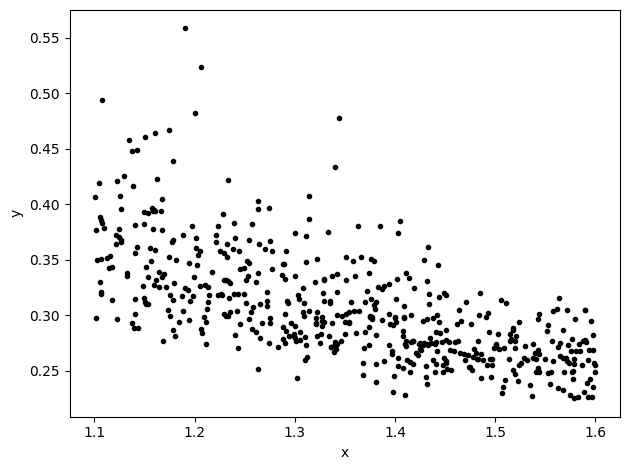

In [3]:
# initial visualization
# scatter plot of the raw data x vs y

fig, ax = plt.subplots(layout="tight")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(rawdata.sort_values("x")["x"], rawdata.sort_values("x")["y"],
           marker=".", color="black")

fig.savefig("figures/before_binning.png")

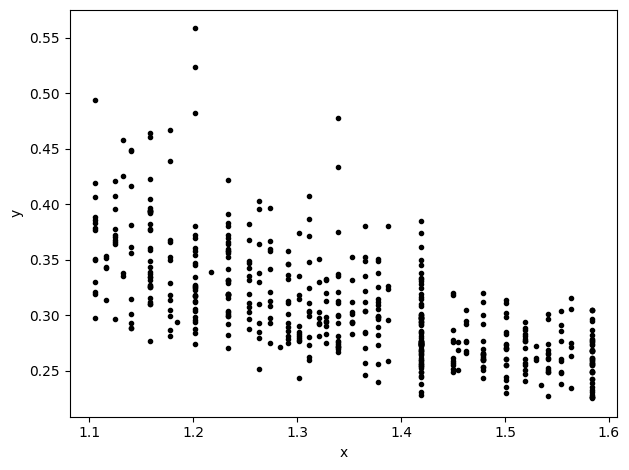

In [4]:
# bin nearly repeated values. Algorithm:
# -check distance between consecutive x values after sorting
# -if consecutive points are below a threshold, bin them together
# here, the threshold is simply some factor times the mean because it is convenient to compute

def bin_nearly_repeated(data, col, factor=0.5):
    """
    A function to bin nearly repeated values, as in
    x    | y         x    | y
    -----+-- becomes -----+--
    1.01 | 2         1.02 | 2
    1.02 | 3         1.02 | 3
    1.03 | 4         1.02 | 4
    Required input:
    - A pandas dataframe
    - The name of the column being binned
    Optional input:
    - The factor by which to scale the threshold; this modifies the mean of the diff and is set to 0.5 by default
    Returns:
    - A sorted pandas dataframe containing a column of binned values "x" with their corresponding values "y", equal in length to the input dataframe
    """
    data.sort_values(col, inplace=True)

    # break the relevant column into sections where consecutive points are within the threshold from each other
    dx = np.diff(data[col])

    threshold = factor*dx.mean()
    
    break_idx = np.argwhere(dx > threshold)[:,0] + 1
    chunks = np.split(np.asarray(data[col]), break_idx)

    #####threshold = 0.1
    #####cx = np.cumsum(dx) % threshold
    #####break_idx = np.argwhere(np.diff(cx) < 0)[:,0] + 1
    #####chunks = np.split(np.asarray(data[col]), break_idx)
    
    # make each element of every chunk equal to the average of the chunk
    # take advantage of the fact that np.split returns views
    for chunk in chunks:
      chunk[:] = chunk.mean()
      
    return data

data = rawdata.copy()
rawdata.sort_values("x", inplace=True)
data = bin_nearly_repeated(data, "x", 2.5) #2.5
#data = rawdata
#data, dfig = bin_nearly_repeated(rawdata, "x", 1, True)
#dfig.savefig("figures/bin_diagnostic.png")

fig, ax = plt.subplots(layout="tight")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(data["x"], data["y"],
           marker=".", color="black")

fig.savefig("figures/after_binning.png")

(-0.23565421110461307,
 0.6258923606482506,
 0.44310340866336095,
 0.8408798516921316,
 <Figure size 640x480 with 2 Axes>)

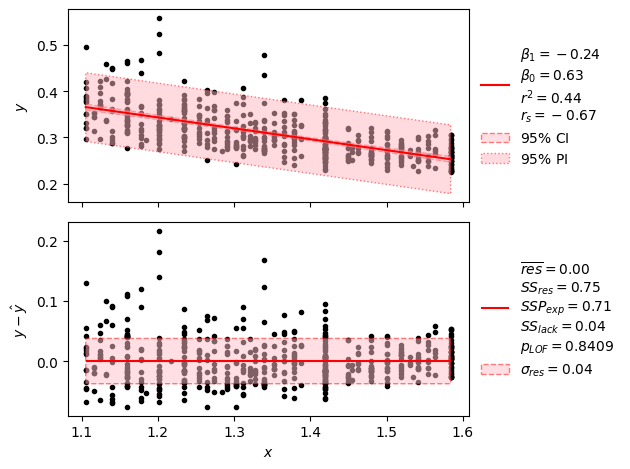

In [5]:
# a function to do the analysis

def fit_and_plot(data, xcol, ycol):
    """
    I'll be doing this many times in the analysis so I made it a function
    required input:
    - a pandas dataframe containing the x and y data
    - the string for the dataframe column with independent values
    - the string for the dataframe column with dependent values
    returns:
    - the slope
    - the intercept
    - the R^2 value
    - pvalue of lack of fit test
    - the figure object that the fit and residuals are drawn on
    """
    # useful quantities
    xbar = data[xcol].mean()
    ybar = data[ycol].mean()
    Sxx = np.sum((data[xcol] - xbar)**2)
    Sxy = np.sum((data[xcol] - xbar) * (data[ycol] - ybar))
    Syy = np.sum((data[ycol] - ybar)**2)

    # estimate fit parameters and add fit + residuals to dataframe
    B1 = Sxy / Sxx
    B0 = ybar - B1*xbar
    fitcol = xcol + ycol + "_fit"
    rescol = xcol + ycol + "_res"
    data[fitcol] = np.polyval([B1, B0], data[xcol])
    data[rescol] = data[ycol] - data[fitcol]
    SSres = np.sum(data[rescol]**2)

    # compute r, r squared, degrees of freedom, and mean squared error
    r = Sxy/np.sqrt(Sxx*Syy)
    rsq = (Syy - SSres) / Syy
    n = len(data)
    dof = n - 2
    MSE = np.sqrt(np.sum((data[ycol] - data[fitcol])**2) / dof)

    # compute .95 confidence and prediction intervals and add to dataframe
    t = stats.t.ppf(0.975, dof)
    CI = t * MSE * np.sqrt(1/n + ((data[xcol]-xbar)**2)/Sxx)
    PI = t * MSE * np.sqrt(1 + 1/n + ((data[xcol]-xbar)**2)/Sxx)

    upper_ci_col = xcol + ycol + "_upperCI"
    lower_ci_col = xcol + ycol + "_lowerCI"
    upper_pi_col = xcol + ycol + "_upperPI"
    lower_pi_col = xcol + ycol + "_lowerPI"

    data[upper_ci_col] = data[fitcol] + CI
    data[lower_ci_col] = data[fitcol] - CI
    data[upper_pi_col] = data[fitcol] + PI
    data[lower_pi_col] = data[fitcol] - PI

    # break data into levels to prepare for lack of fit test
    break_idx = np.nonzero(np.diff(data[xcol]))[0] + 1
    levels_x = np.split(np.asarray(data[xcol]), break_idx)
    levels_y = np.split(np.asarray(data[ycol]), break_idx)

    # find pure experimental error and error due to lack of fit
    SSPexp = 0
    SSPexp_dof = 0
    for ly in levels_y:
        lybar = ly.mean()
        SSPexp += np.sum((ly - lybar)**2)
        SSPexp_dof += len(ly) - 1
    SSlack = SSres - SSPexp
    SSlack_dof = n - 2 - SSPexp_dof

    # calculate the statistic and result of the lack of fit test
    F0 = (SSPexp*SSlack_dof) / (SSlack*SSPexp_dof)
    pLOF = stats.f.cdf(F0, SSPexp_dof, SSlack_dof)

    # visualize
    fig, (fax, rax) = plt.subplots(2, layout="tight",
                                   sharex=True)

    # plot the fit
    fax.set_ylabel("$"+ycol+"$")
    fax.scatter(data[xcol], data[ycol],
                marker=".", color="black")
    l = "$\\beta_1 = %.2f$\n$\\beta_0 = %.2f$\n$r^2 = %.2f$\n$r_{s} = %.2f$"\
         %(B1, B0, rsq, r)
    fax.plot(data[xcol], data[fitcol],
             color="red", label=l)
    
    # plot .95 CI and PI
    fax.fill_between(data[xcol], data[upper_ci_col], data[lower_ci_col],
                     color="pink", alpha=0.5,
                     edgecolor="red", linestyle="dashed",
                     label="$95\%$ CI")
    fax.fill_between(data[xcol], data[upper_pi_col], data[lower_pi_col],
                     color="lightpink", alpha=0.5,
                     edgecolor="red", linestyle="dotted",
                     label="$95\%$ PI")

    fax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    # residuals with mean and 1 sigma error band
    rax.set_ylabel("$"+ycol+"-\hat{y}$")
    rax.set_xlabel("$"+xcol+"$")
    rax.scatter(data[xcol], data[rescol],
                marker=".", color="black")
    res_mean = data[rescol].mean()
    res_std_dev = np.std(data[rescol])
    l = "$\\overline{res} = %.2f$\n$SS_{res} = %.2f$\n$SSP_{exp} = %.2f$\n$SS_{lack} = %.2f$\n$p_{LOF} = %.4f$"\
        %(res_mean, SSres, SSPexp, SSlack, pLOF)
    rax.hlines(res_mean, min(data[xcol]), max(data[xcol]),
               color="red", label=l)
    l = "$\\sigma_{res} = %.2f$" %res_std_dev
    rax.fill_between(data[xcol], res_mean+res_std_dev, res_mean-res_std_dev,
                     color="pink", alpha=0.5,
                     edgecolor="red", linestyle="dashed",
                     label=l)
    rax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    return B1, B0, rsq, pLOF, fig
fit_and_plot(data, "x", "y")

In [6]:
# apply some transformations

def root(data, col, name):
    data[name+col] = np.sqrt(data[col])
def log(data, col, name):
    data[name+col] = np.log(data[col])
def inverse(data, col, name):
    data[name+col] = 1.0/data[col]
def square(data, col, name):
    data[name+col] = data[col]**2
def no_trans(data, col, name):
    pass

trans_names = [
    "Root",
    "Log",
    "Inverse",
    "Square"
]
trans_funcs = [
    root,
    log,
    inverse,
    square
]

for name, func in zip(trans_names, trans_funcs):
    func(data, "x", name)
    func(data, "y", name)
    func(rawdata, "x", name)
    func(rawdata, "y", name)

In [7]:
data2 = rawdata.copy()
for name in trans_names:
    data2 = bin_nearly_repeated(rawdata, name+"x", 2.5)

/tmp/ipykernel_88170/2114481572.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (fax, rax) = plt.subplots(2, layout="tight",
/tmp/ipykernel_88170/2114481572.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[fitcol] = np.polyval([B1, B0], data[xcol])
/tmp/ipykernel_88170/2114481572.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

[['Rootx_Rooty', -0.4865076369291176, 1.1175013067915351, 0.4629393431820017, 0.912412947161418, <Figure size 640x480 with 2 Axes>], ['Rootx_Logy', -1.737675429308933, 0.8253820405961028, 0.4768147704655304, 0.9162590872153009, <Figure size 640x480 with 2 Axes>], ['Rootx_Inversey', 5.625101646098584, -3.1987714914244716, 0.4939558649893351, 0.9075711009924904, <Figure size 640x480 with 2 Axes>], ['Rootx_Squarey', -0.352836911733055, 0.5066417847173875, 0.39998928074163614, 0.8809114806526036, <Figure size 640x480 with 2 Axes>], ['Rootx_y', -0.5476954014759486, 0.9432346789547986, 0.44543293169109177, 0.9044104609289351, <Figure size 640x480 with 2 Axes>], ['Logx_Rooty', -0.2816731599351202, 0.6359717664487295, 0.4642747195266949, 0.9393755676822836, <Figure size 640x480 with 2 Axes>], ['Logx_Logy', -1.005524699752708, -0.894671042260754, 0.4776801595385784, 0.9343524379355719, <Figure size 640x480 with 2 Axes>], ['Logx_Inversey', 3.25158154915899, 2.370298778008207, 0.49380562819403717

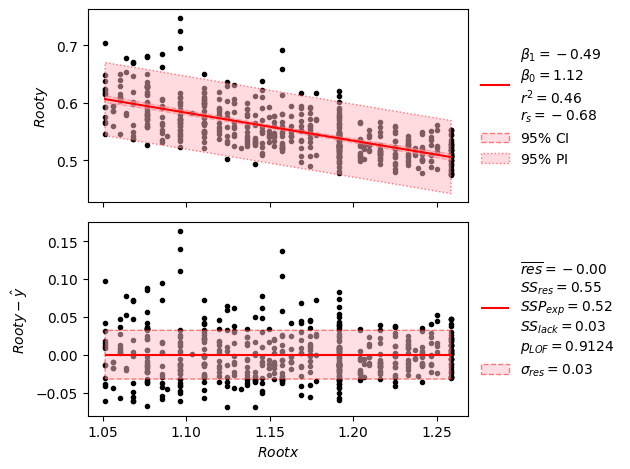

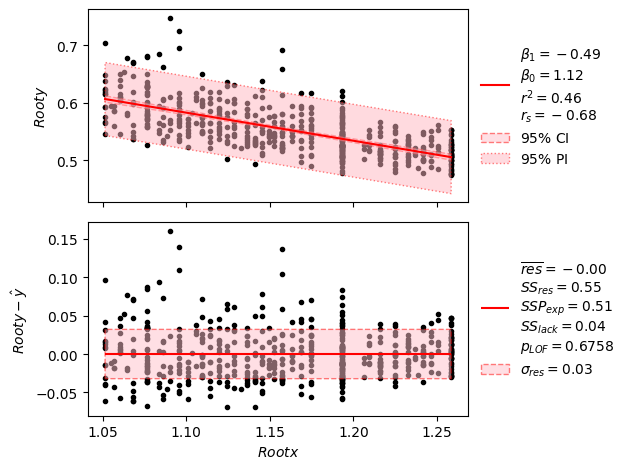

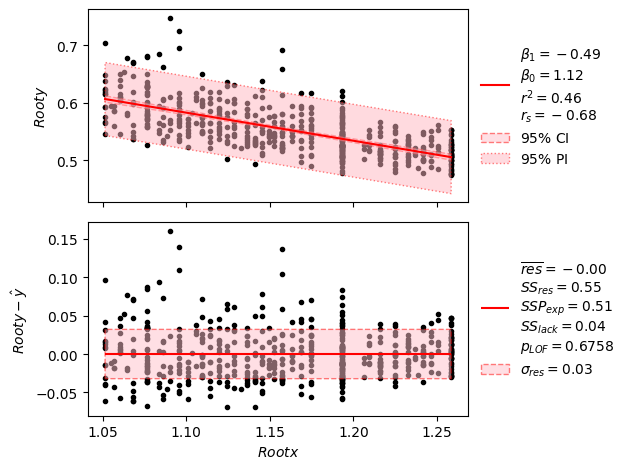

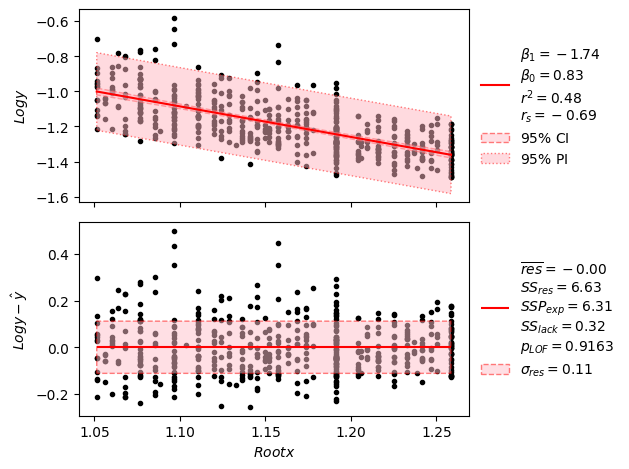

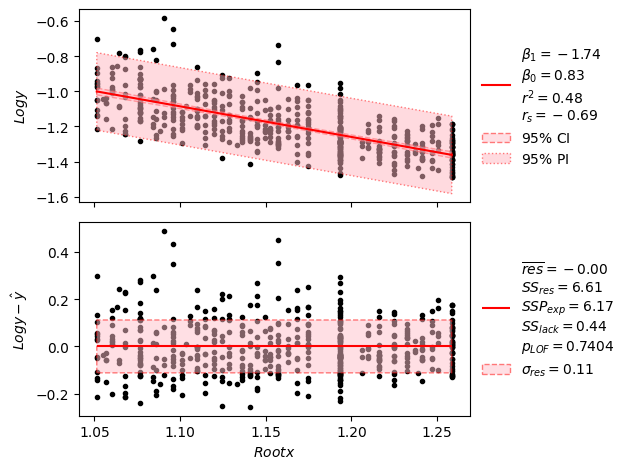

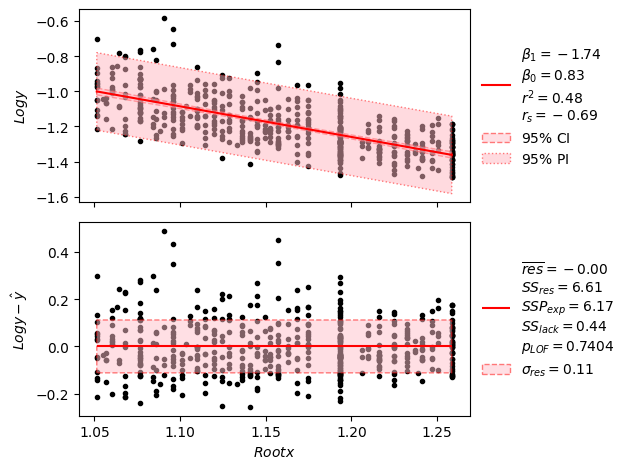

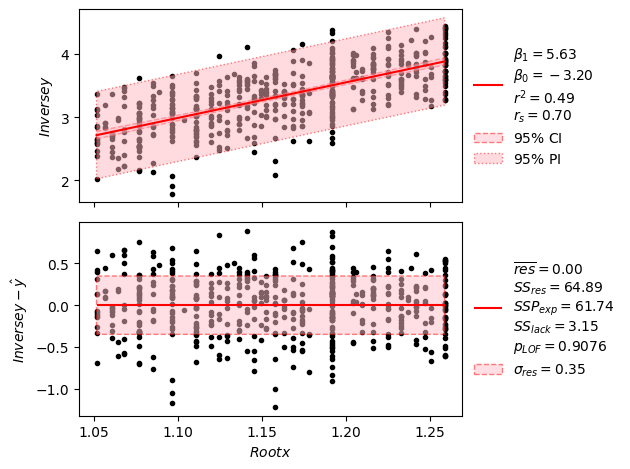

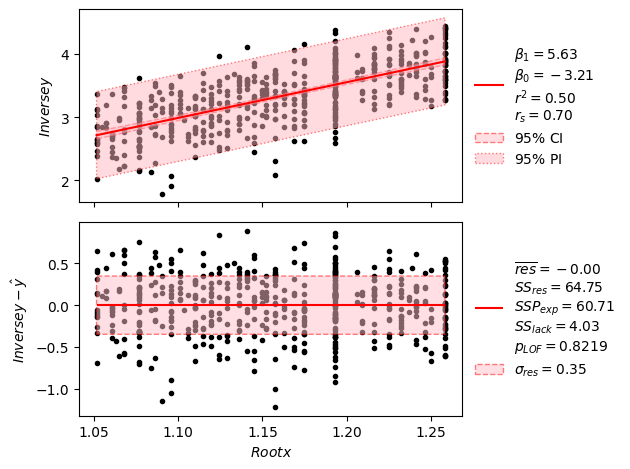

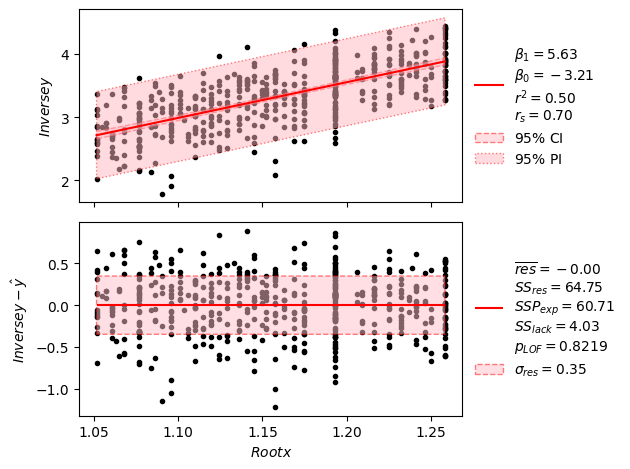

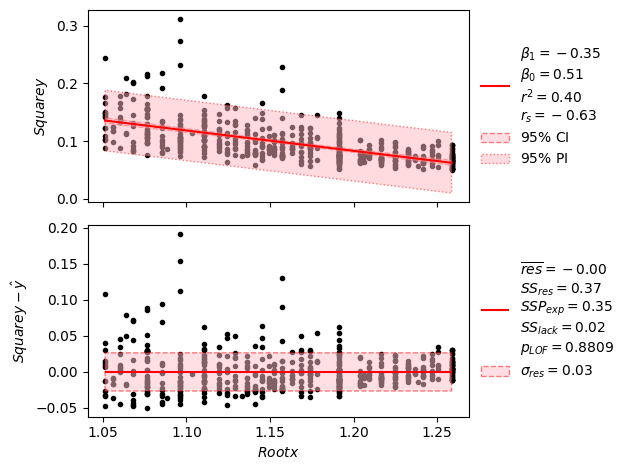

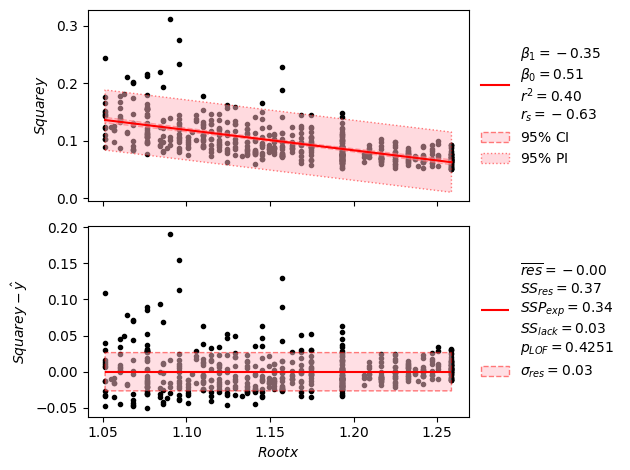

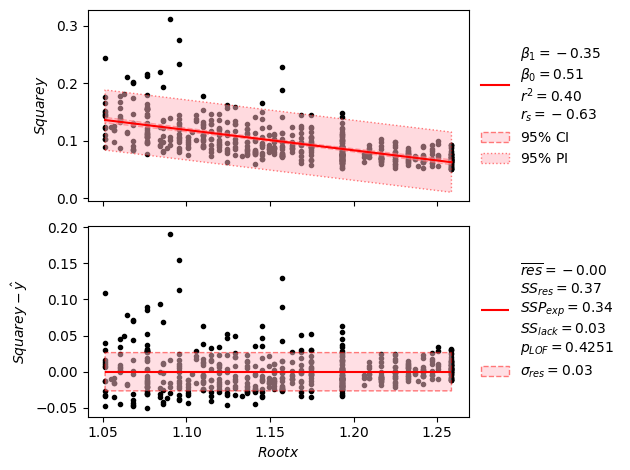

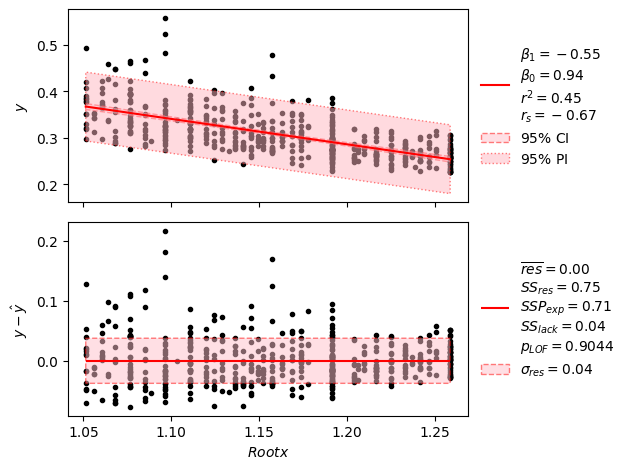

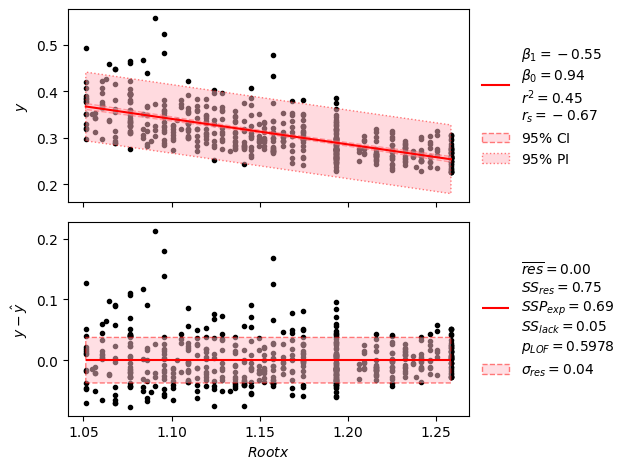

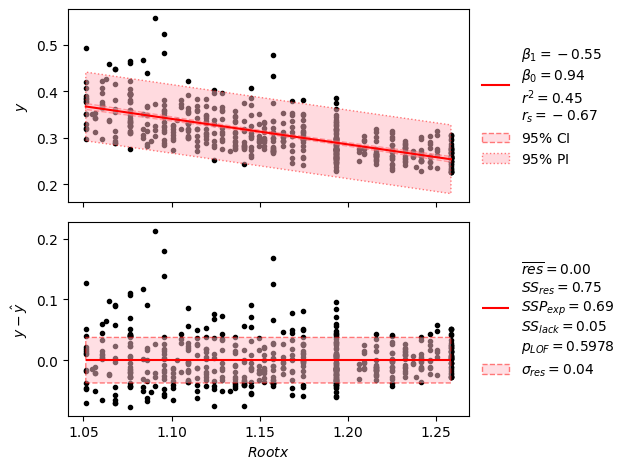

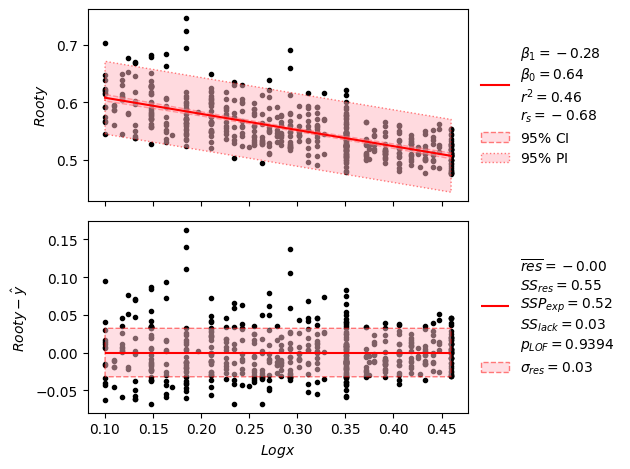

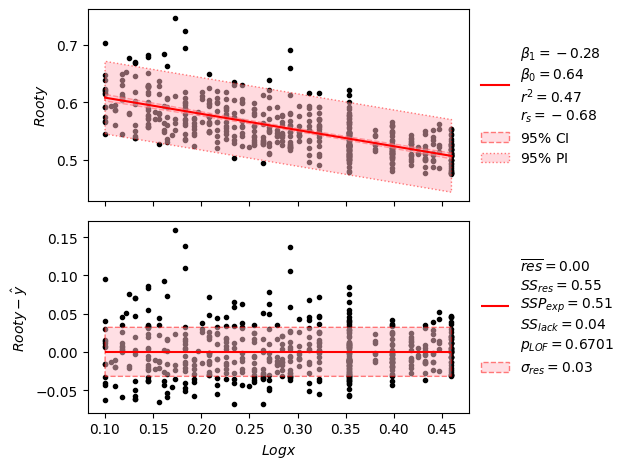

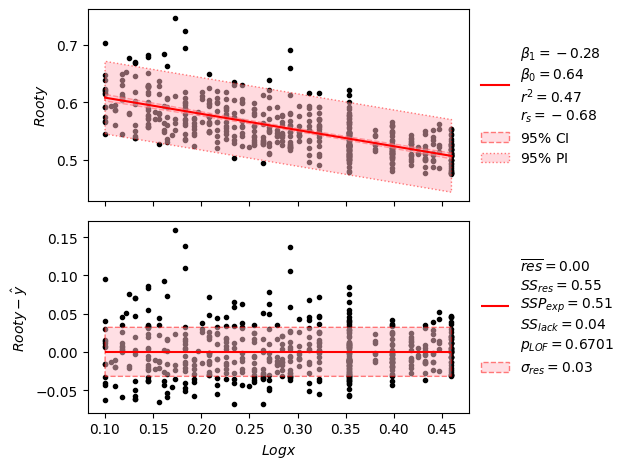

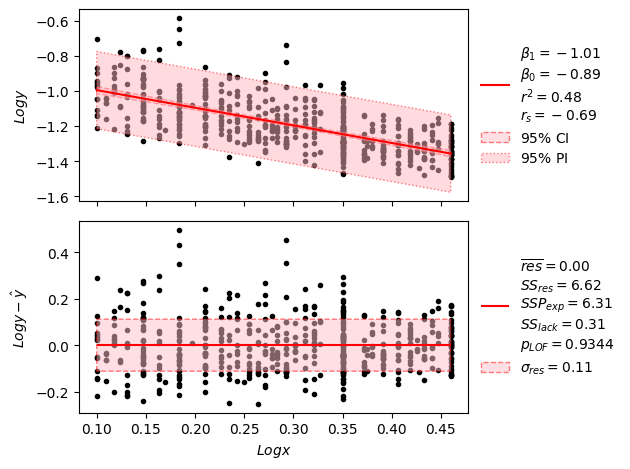

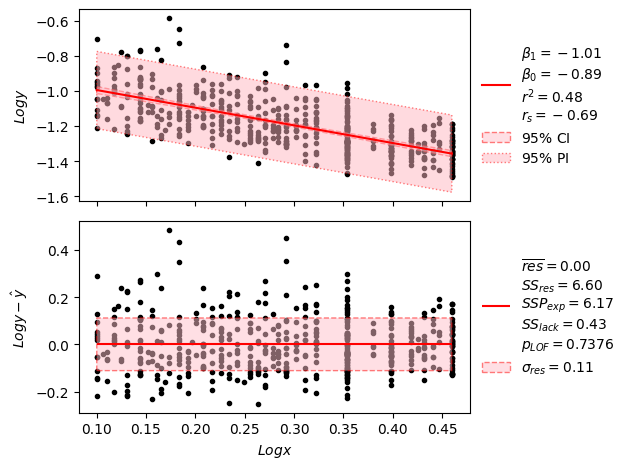

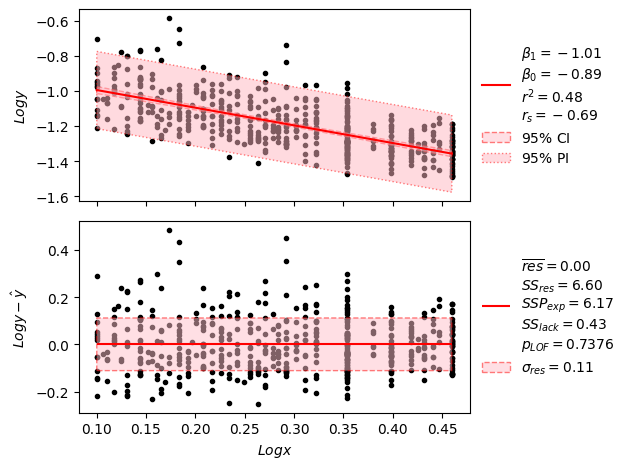

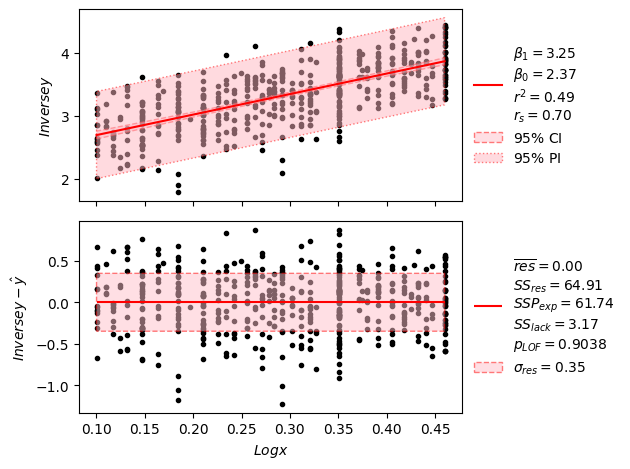

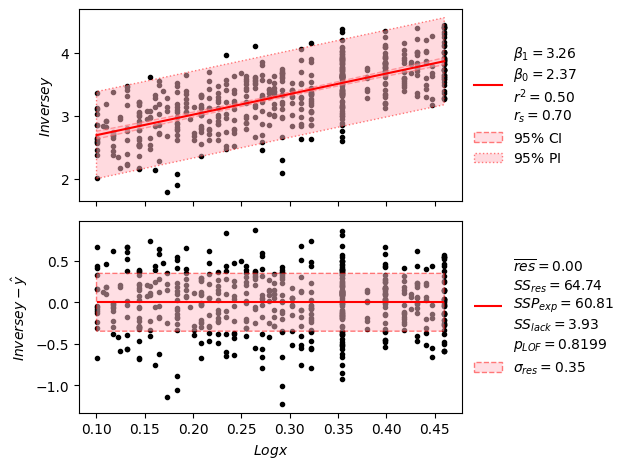

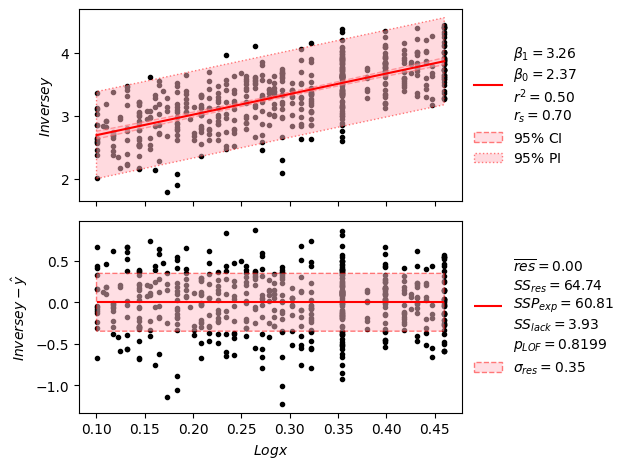

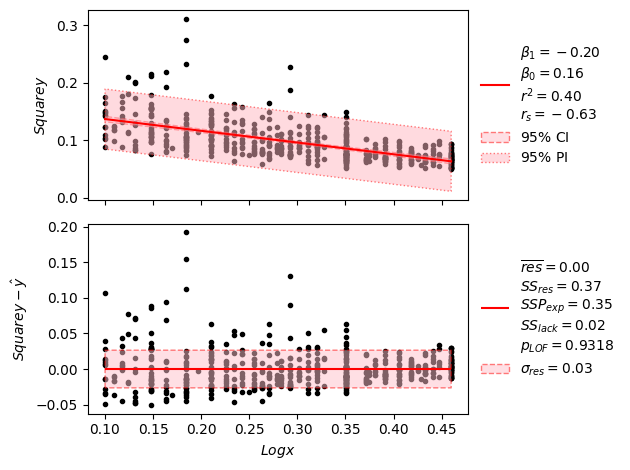

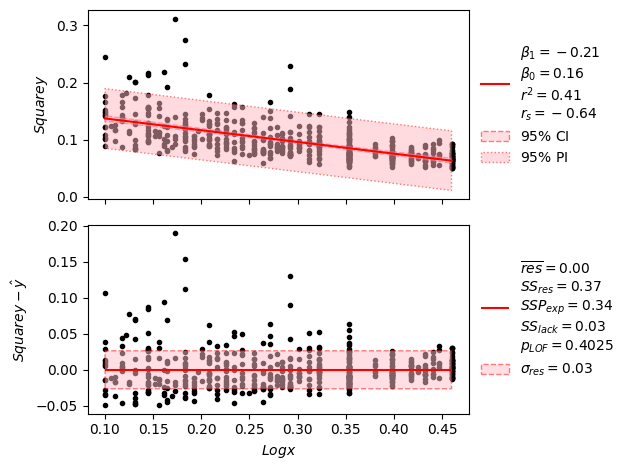

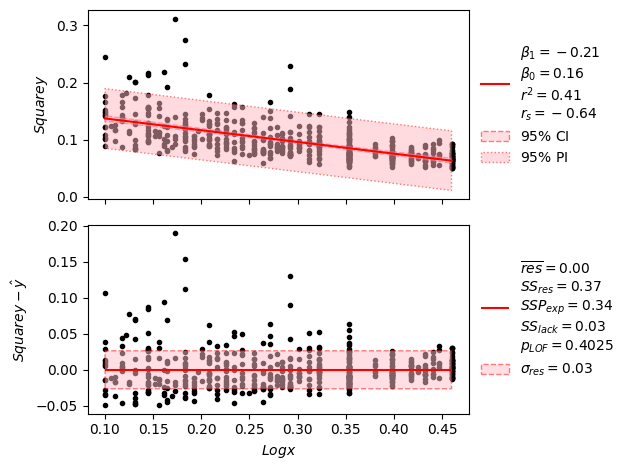

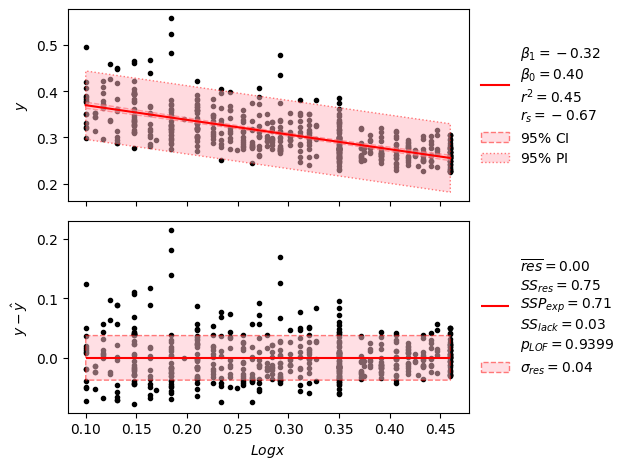

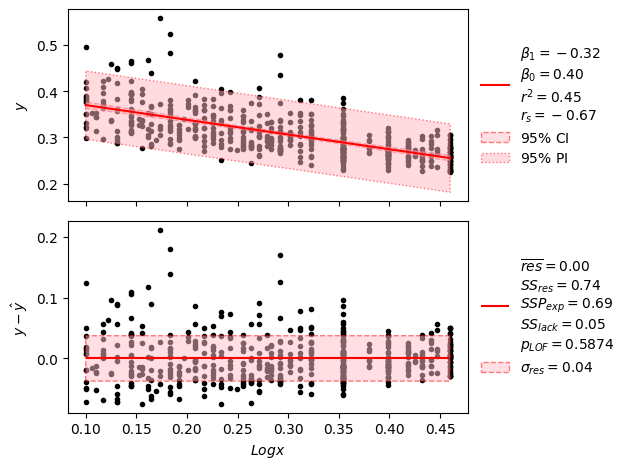

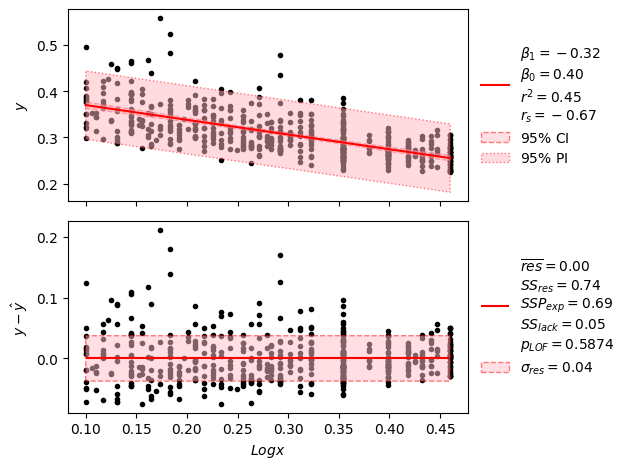

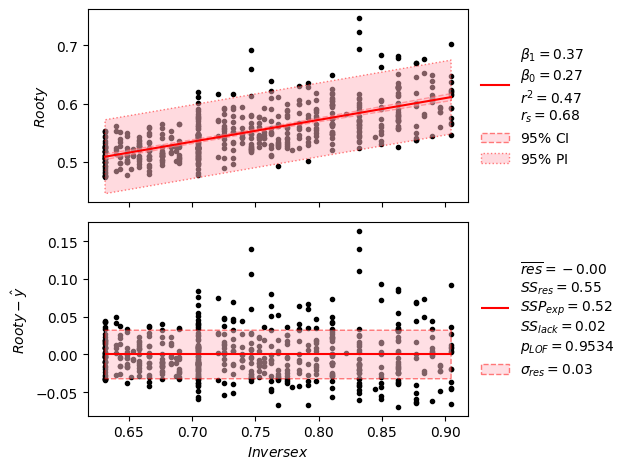

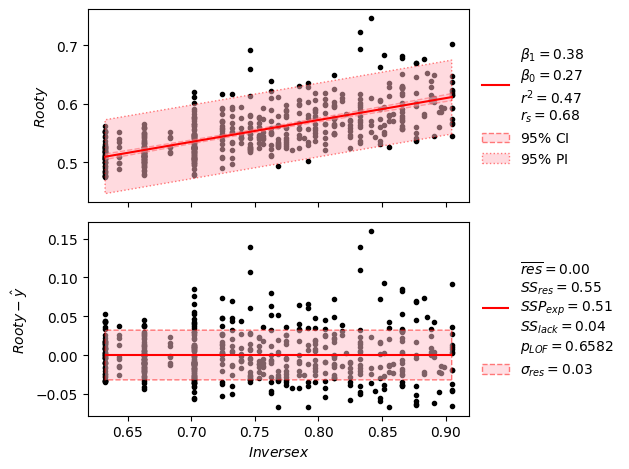

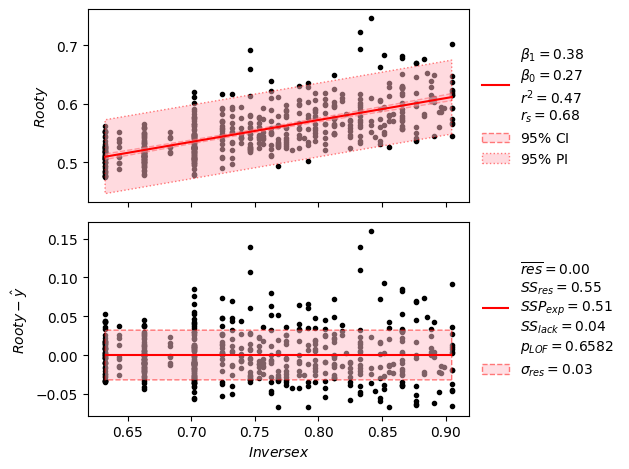

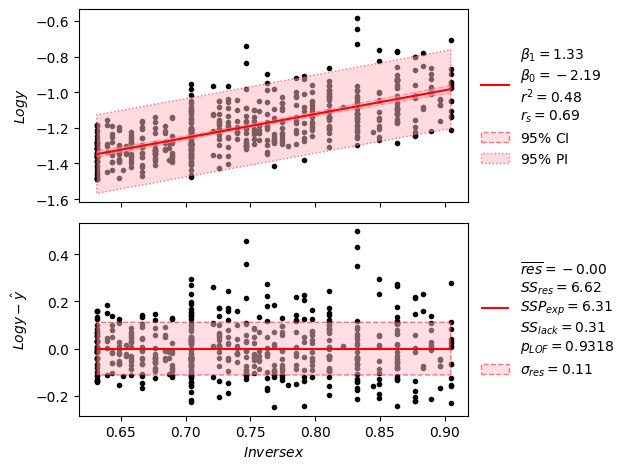

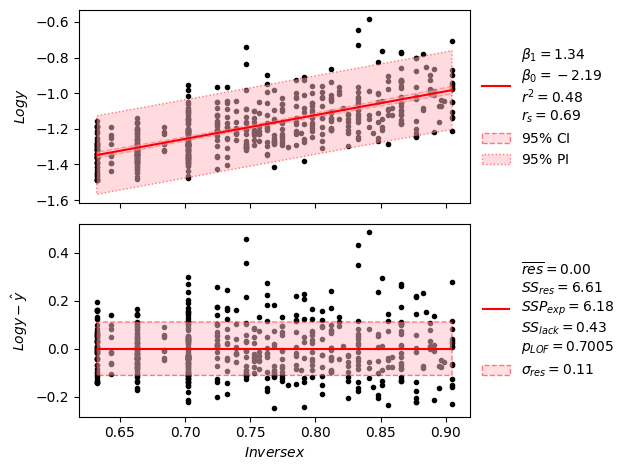

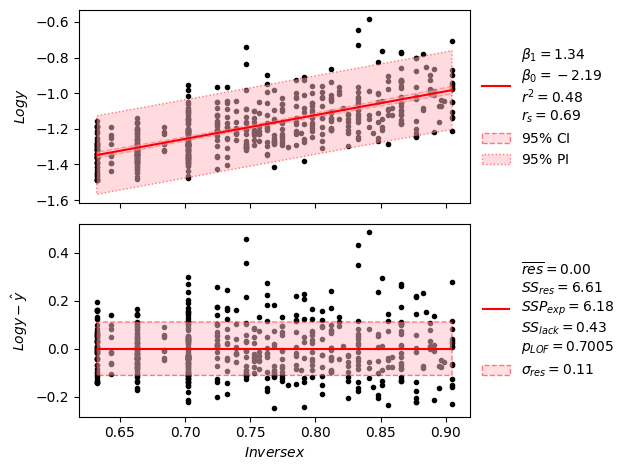

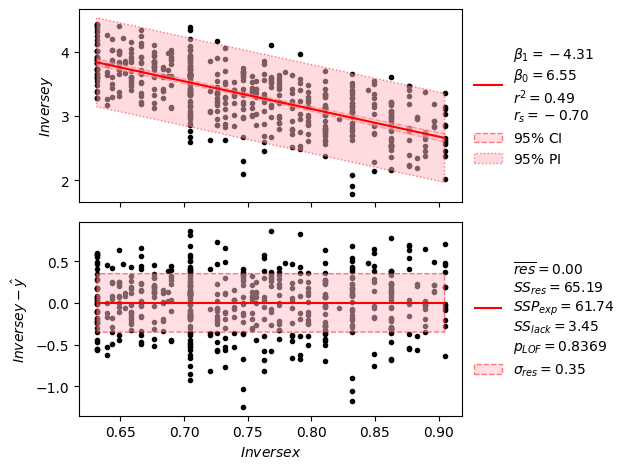

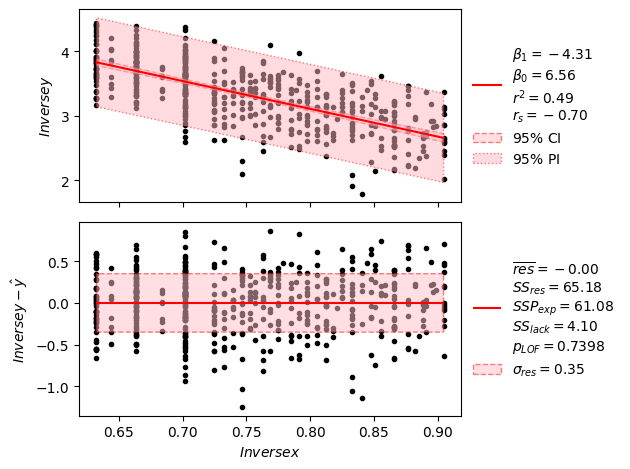

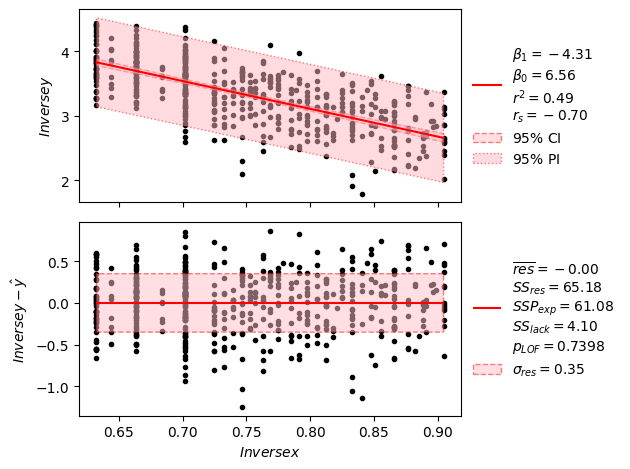

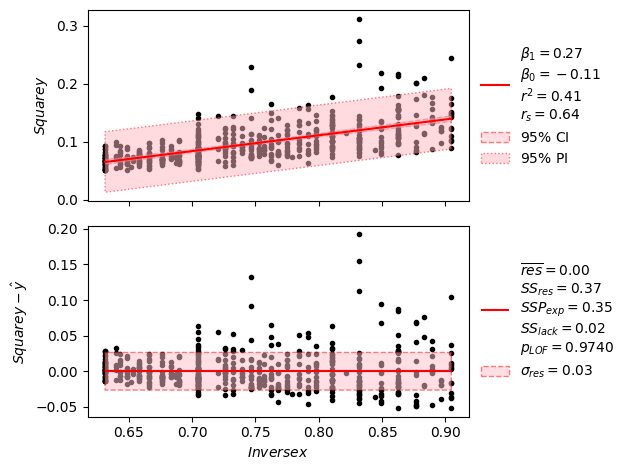

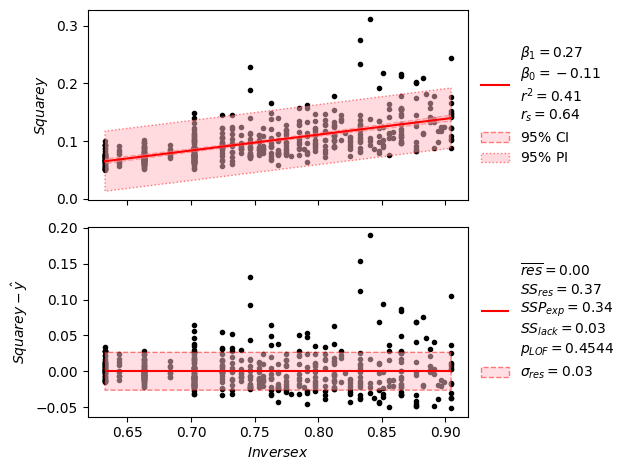

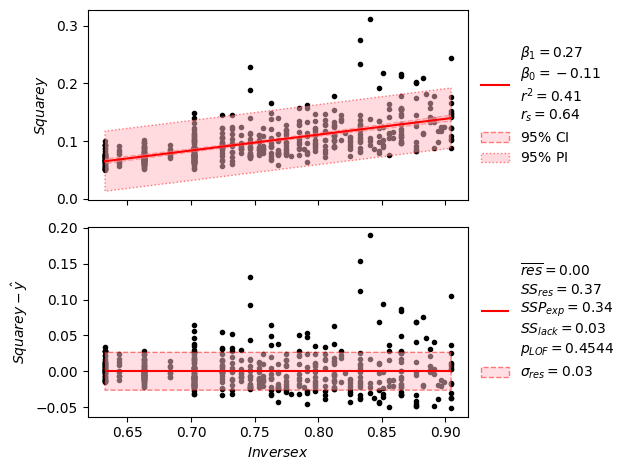

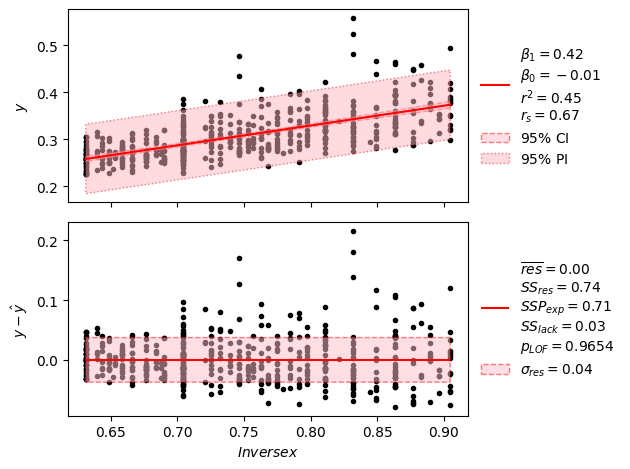

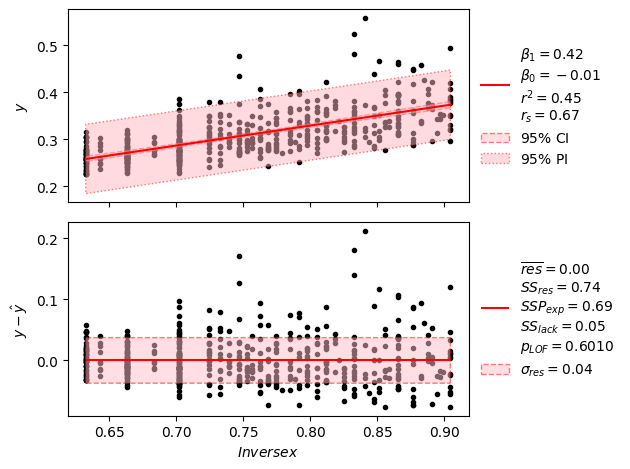

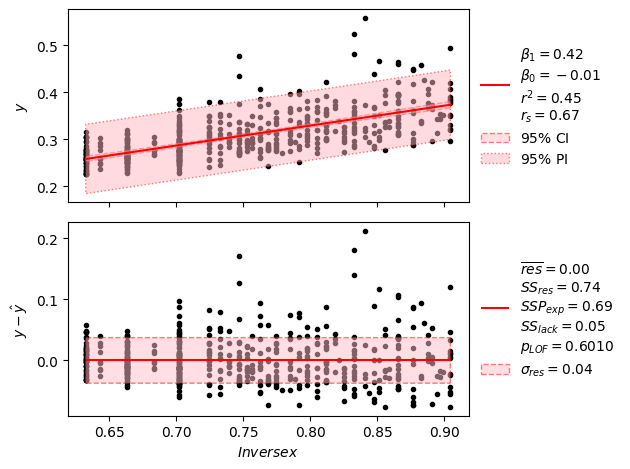

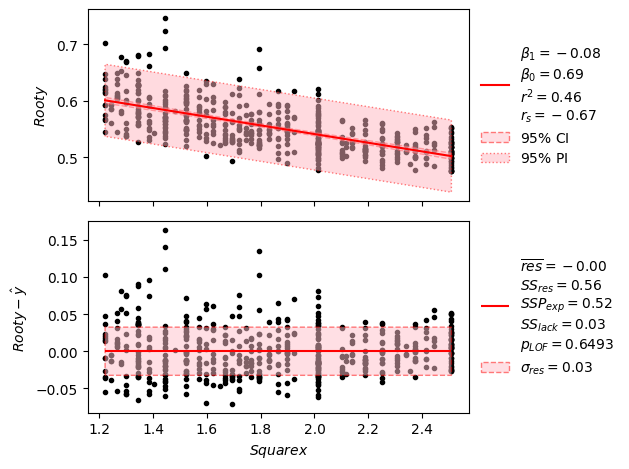

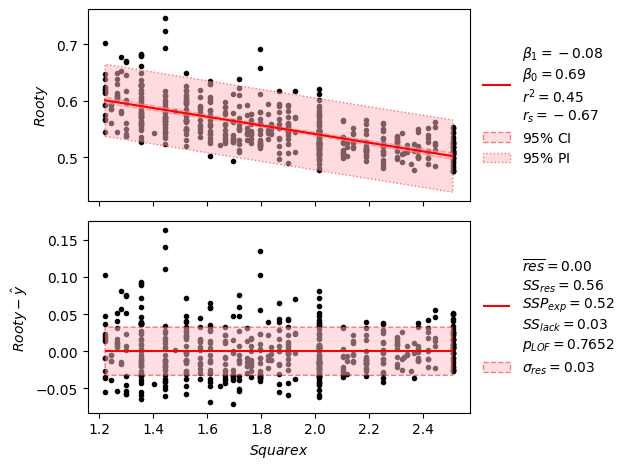

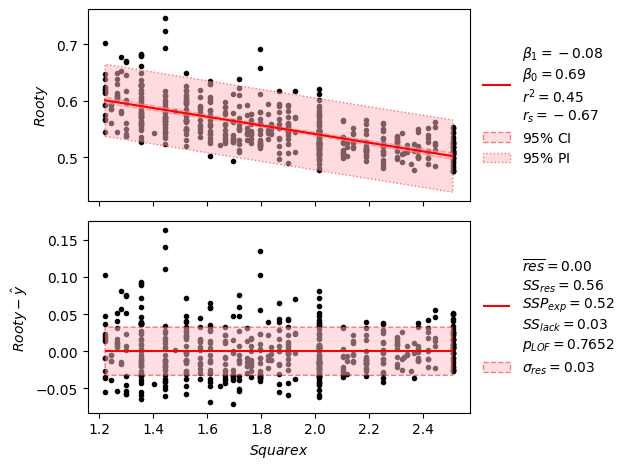

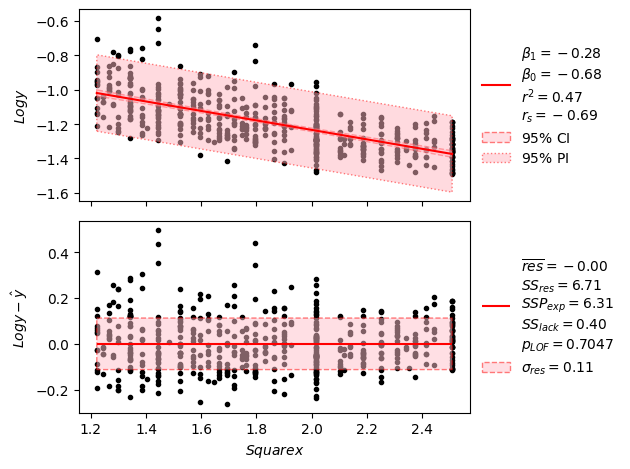

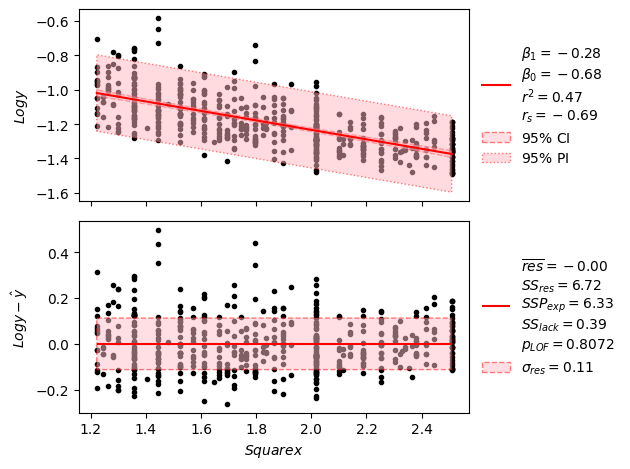

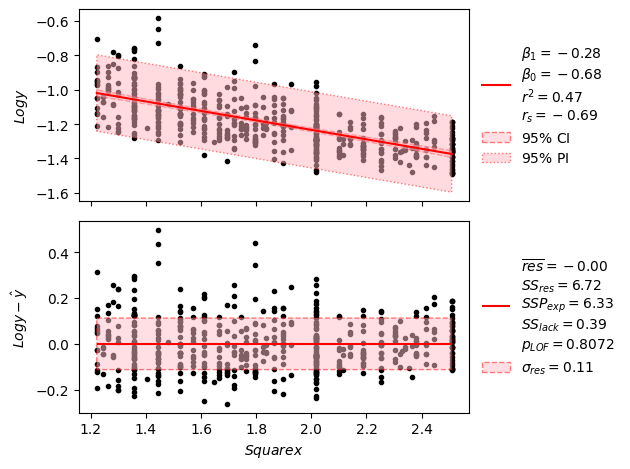

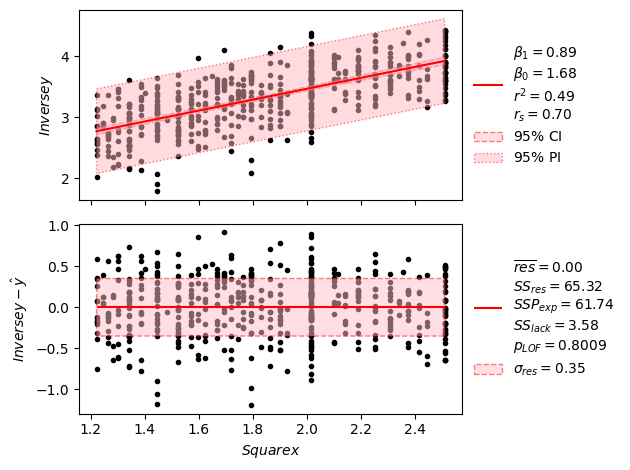

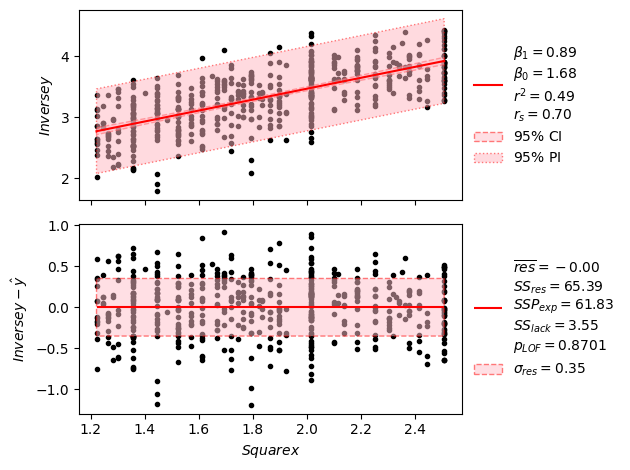

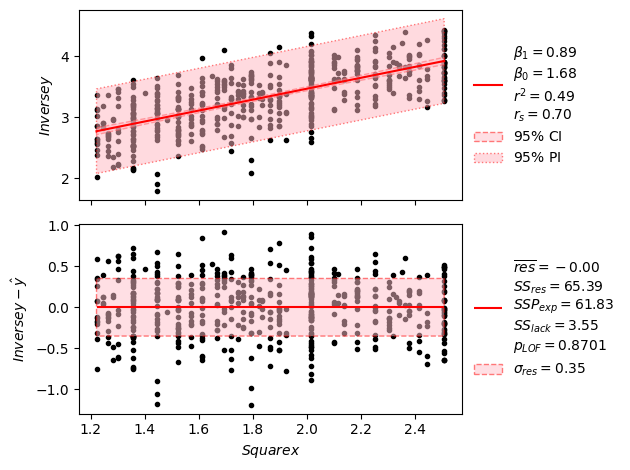

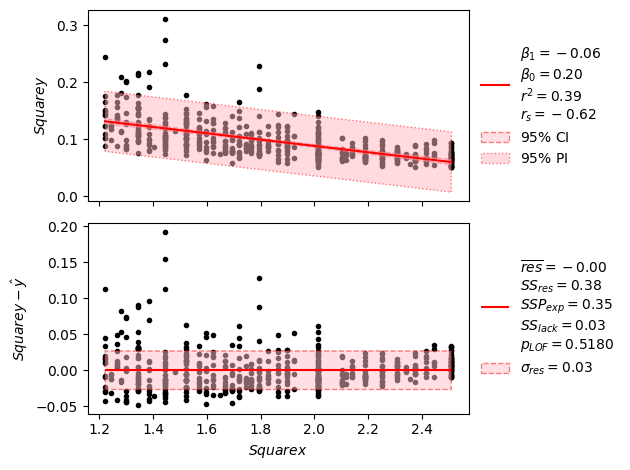

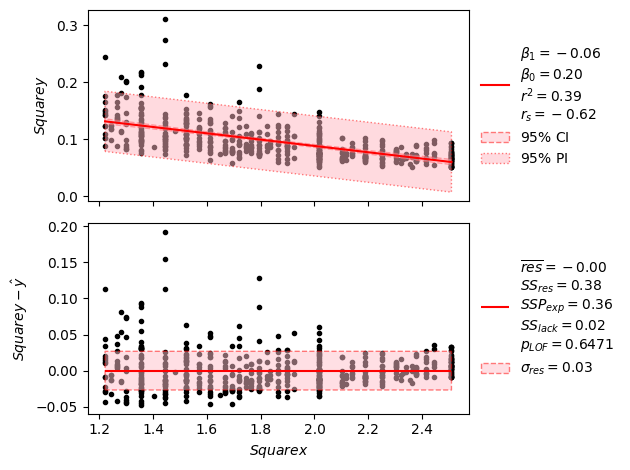

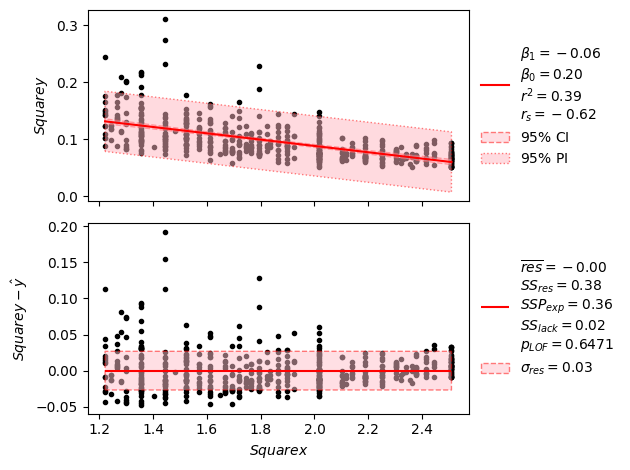

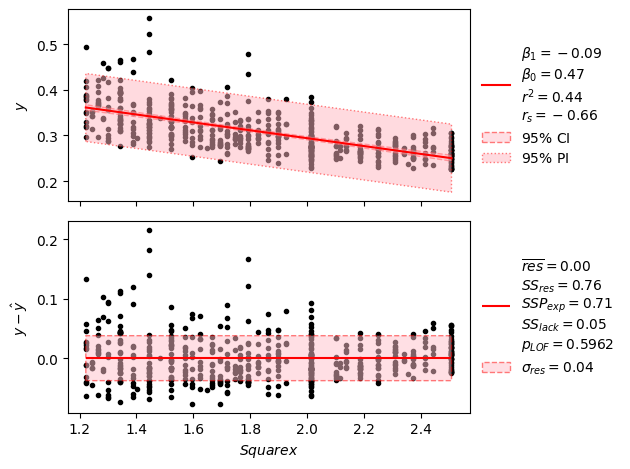

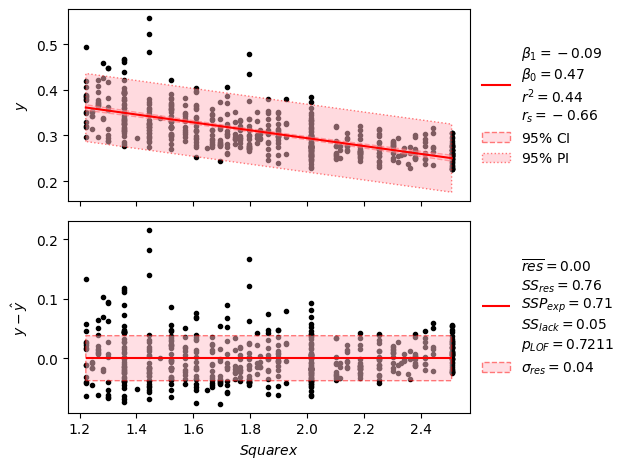

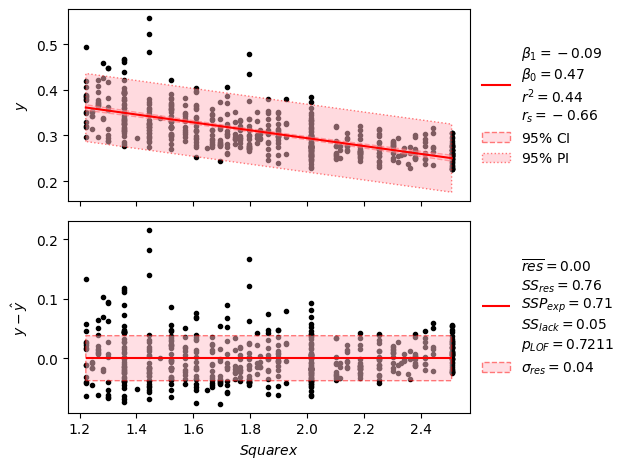

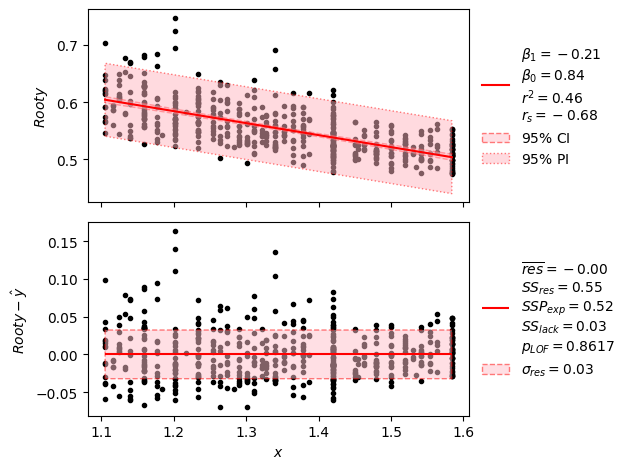

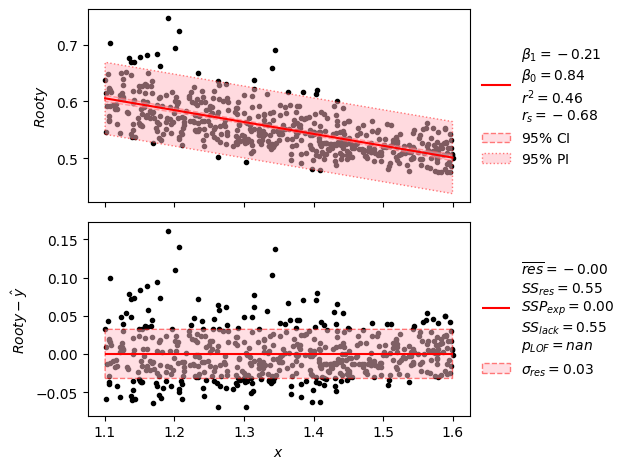

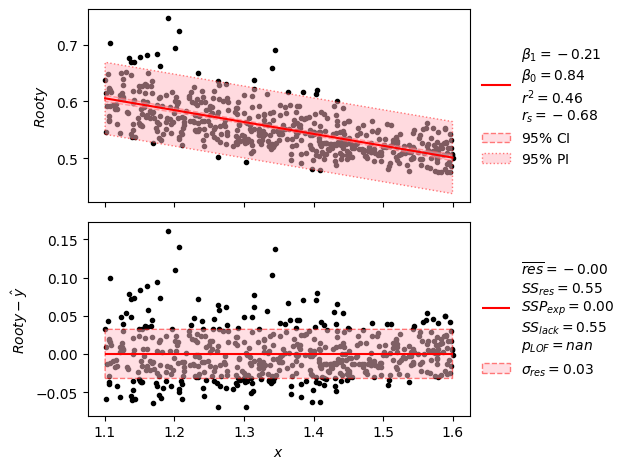

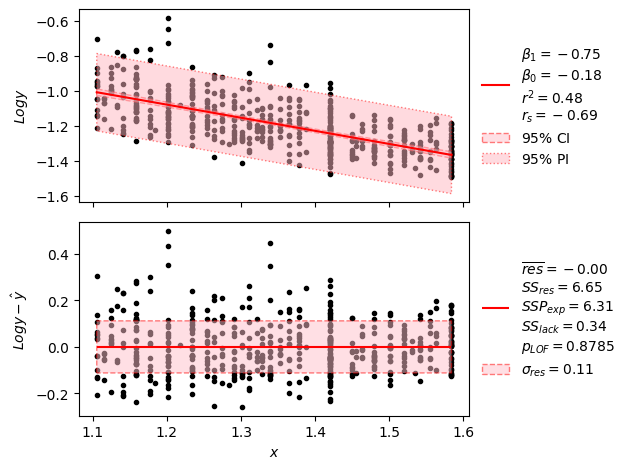

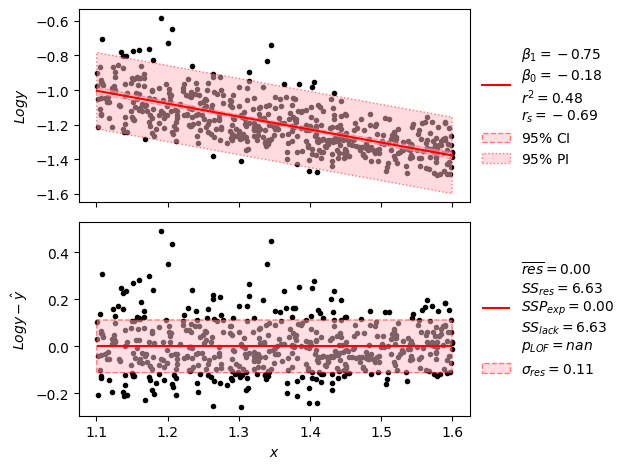

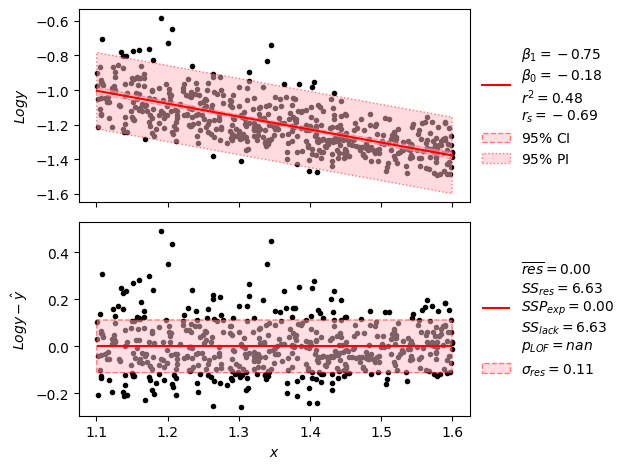

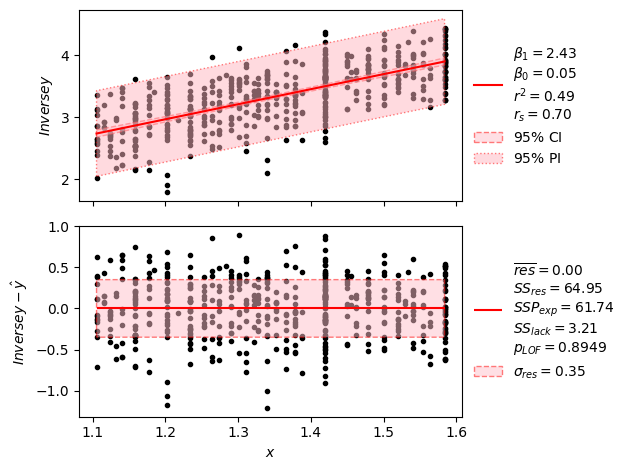

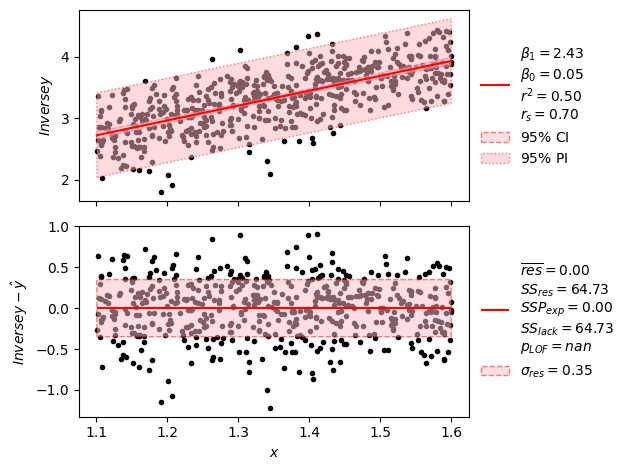

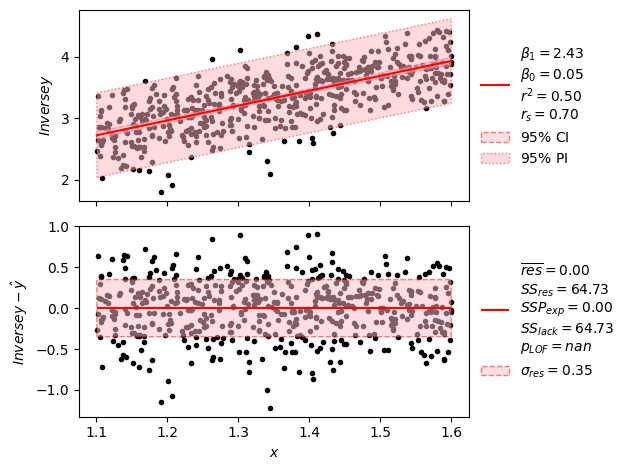

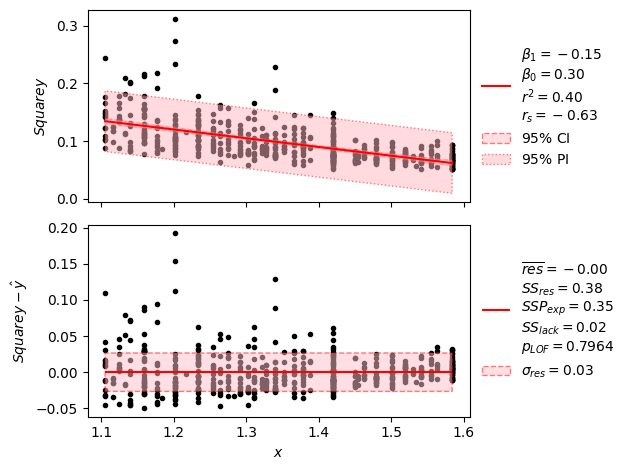

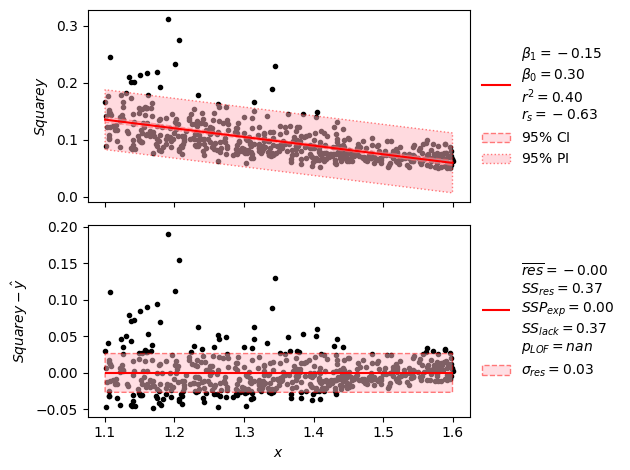

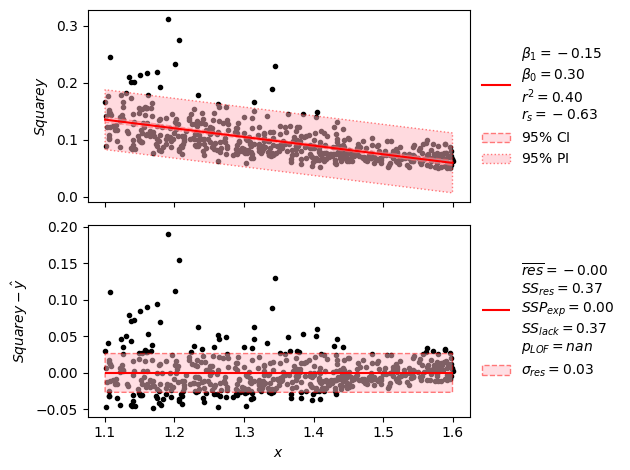

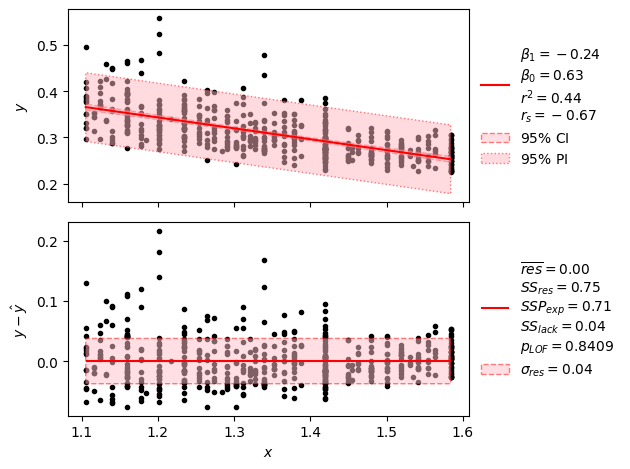

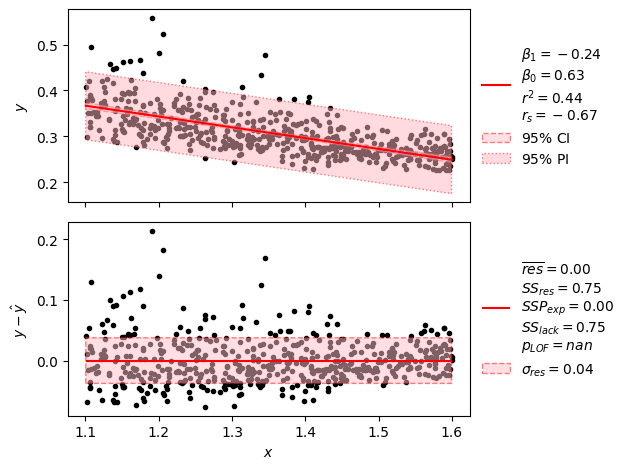

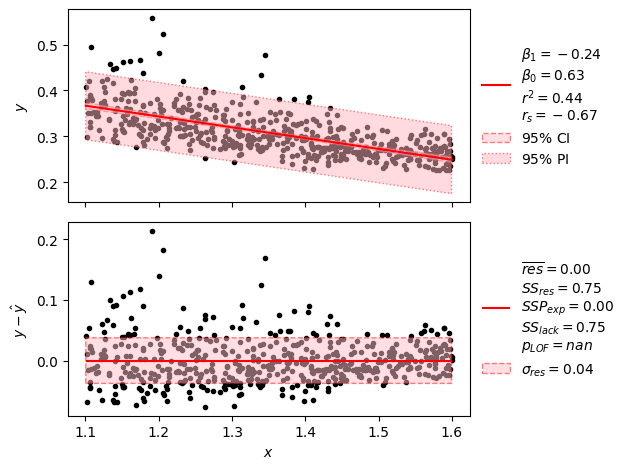

In [8]:
# call analysis function on each permutation with replacement

trans_names.append("")
binned_results = []
alt_results = []
raw_results = []
for p in product(trans_names, repeat=2):
    thisx = p[0]+"x"
    thisy = p[1]+"y"
    thisp = thisx + "_" + thisy
    binned_results.append([thisp, *fit_and_plot(data, thisx, thisy)])
    alt_results.append([thisp, *fit_and_plot(data2, thisx, thisy)])
    raw_results.append([thisp, *fit_and_plot(rawdata, thisx, thisy)])
print(binned_results)

In [13]:
# save all figures to disk
for b, r, a in zip(binned_results, raw_results, alt_results):
    b[5].savefig("figures/%s_binned.png" %b[0])
    r[5].savefig("figures/%s_raw.png" %r[0])
    a[5].savefig("figures/%s_alt.png" %a[0])

x_Inversey Logx_Inversey


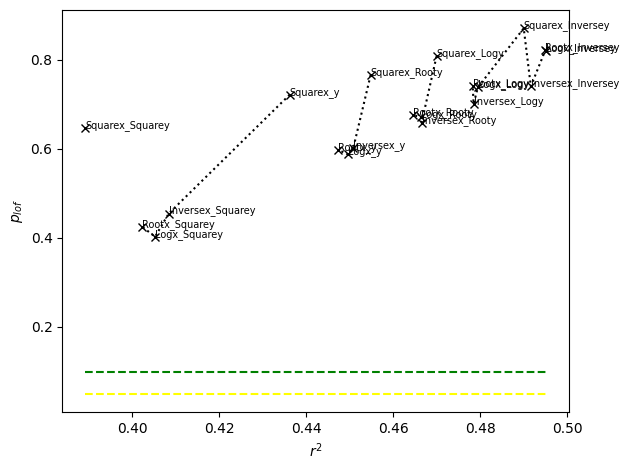

In [12]:
# sort results by r value
by_rsq = sorted(alt_results, key=lambda binned_results: binned_results[3], reverse=True)
print(by_rsq[0][0],by_rsq[1][0])
#print("=== BY R^2 ===")
#for x in by_rsq:
#    print(x)

# sort results by pLOF
by_pLOF = sorted(binned_results, key=lambda binned_results: binned_results[4], reverse=True)
#print("=== BY pLOF ===")
#for x in by_pLOF:
#    print(x)

# check for correlation between r^2 and pLOF
rsq_vals = [x[3] for x in by_rsq]
pLOF_vals = [y[4] for y in by_rsq]
trans = [l[0] for l in by_rsq]

fig, ax = plt.subplots(layout="tight")
ax.set_xlabel("$r^2$")
ax.set_ylabel("$p_{lof}$")
ax.plot(rsq_vals, pLOF_vals,
        marker="x", linestyle="dotted",
        color="black")
for l, x, y in zip(trans, rsq_vals, pLOF_vals):
    ax.annotate(l, (x,y), size=7)#, rotation=15)

ax.hlines(0.05, min(rsq_vals), max(rsq_vals),
          color="yellow", linestyle="dashed")
ax.hlines(0.10, min(rsq_vals), max(rsq_vals),
          color="green", linestyle="dashed")

fig.savefig("figures/rsq_vs_plof.png")

In [11]:
print(data)
print(data.memory_usage().sum()/1000, "mb")

      ID         x         y    xy_fit    xy_res  xy_upperCI  xy_lowerCI   
237  238  1.105333  0.406891  0.365416  0.041475    0.371805    0.359027  \
278  279  1.105333  0.377258  0.365416  0.011842    0.371805    0.359027   
9     10  1.105333  0.297415  0.365416 -0.068001    0.371805    0.359027   
521  522  1.105333  0.350334  0.365416 -0.015082    0.371805    0.359027   
229  230  1.105333  0.419560  0.365416  0.054144    0.371805    0.359027   
..   ...       ...       ...       ...       ...         ...         ...   
68    69  1.583951  0.282649  0.252628  0.030021    0.258805    0.246451   
213  214  1.583951  0.235554  0.252628 -0.017074    0.258805    0.246451   
81    82  1.583951  0.257472  0.252628  0.004844    0.258805    0.246451   
281  282  1.583951  0.255648  0.252628  0.003021    0.258805    0.246451   
496  497  1.583951  0.249281  0.252628 -0.003346    0.258805    0.246451   

     xy_upperPI  xy_lowerPI     Rootx  ...  xInversey_upperCI   
237    0.439694    0.2